# Reinforce



**References:**
- https://gym.openai.com/envs/Blackjack-v0/
- https://github.com/philtabor/Actor-Critic-Methods-Paper-To-Code

## Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

## Policy Network

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(PolicyNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        
        self.fc1 = nn.Linear(*self.observation_space, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.action_space)
        
        self.optimizer = optim.Adam(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        layer1 = F.relu(self.fc1(observation))
        layer2 = F.relu(self.fc2(layer1))
        actions = self.fc3(layer2)

        return actions

## Reinforcement Learning Agent

In [3]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.0005, discount_rate = 0.99):
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.policy = PolicyNetwork(self.observation_space, self.action_space, self.learning_rate)
        
        self.reward_memory = []
        self.action_memory = []

    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.policy.device)
        probabilities = F.softmax(self.policy.forward(state))
        action_probs = T.distributions.Categorical(probabilities)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_memory.append(log_probs)

        return action.item()

    def store_rewards(self, reward):
        self.reward_memory.append(reward)

    def learn(self):
        self.policy.optimizer.zero_grad()

        # G_t = R_t+1 + gamma * R_t+2 + gamma**2 * R_t+3
        # G_t = sum from k=0 to k=T {gamma**k * R_t+k+1}
        G = np.zeros_like(self.reward_memory, dtype = np.float64)
        for t in range(len(self.reward_memory)):
            G_sum = 0
            discount = 1
            for k in range(t, len(self.reward_memory)):
                G_sum += self.reward_memory[k] * discount
                discount *= self.discount_rate
            G[t] = G_sum
        G = T.tensor(G, dtype=T.float).to(self.policy.device)
        
        loss = 0
        for g, logprob in zip(G, self.action_memory):
            loss += -g * logprob
        loss.backward()
        self.policy.optimizer.step()

        self.action_memory = []
        self.reward_memory = []

## Main Program

In [4]:
step = 0
episodes = 30

<ipython-input-3-e29f823f3352>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(self.policy.forward(state))


episode  0 score -133.23 average score -133.23
episode  1 score -88.00 average score -110.62
episode  2 score -88.29 average score -103.17
episode  3 score -93.87 average score -100.85
episode  4 score -58.09 average score -92.29
episode  5 score -236.99 average score -116.41
episode  6 score -180.30 average score -125.54
episode  7 score -313.75 average score -149.06
episode  8 score -307.56 average score -166.67
episode  9 score -278.64 average score -177.87
episode  10 score -138.03 average score -174.25
episode  11 score -275.40 average score -182.68
episode  12 score -82.82 average score -175.00
episode  13 score -109.88 average score -170.34
episode  14 score -307.49 average score -179.49
episode  15 score -318.20 average score -188.16
episode  16 score -120.70 average score -184.19
episode  17 score -114.12 average score -180.30
episode  18 score -365.71 average score -190.06
episode  19 score 21.10 average score -179.50
episode  20 score -116.44 average score -176.49
episode  2

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

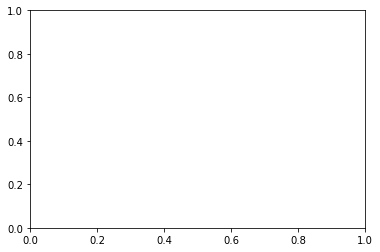

In [5]:
env = gym.make('LunarLander-v2')

observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = Agent(observation_space, action_space)

scores, steps = [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0
    
    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, _ = env.step(action)
        observation = next_observation
        score += reward
        step += 1
        agent.store_rewards(reward)
        
    agent.learn()
    scores.append(score)

    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score)

x = [i+1 for i in range(len(scores))]
plot_learning_curve(scores, steps)

In [13]:
action_space

4